In [2]:
import sys
sys.path.insert(0,'/Users/nakaa1/code/py/PsychRNN')

import psychrnn
from psychrnn.tasks import rdm as rd
from psychrnn.backend.models.basic import Basic, BasicSigmoid
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
import importlib
importlib.reload(psychrnn)

from brian2 import *

define params globally first before passing to RDM, mess w/ model params and explain what can do. (can turn on and off dale's law). some masking, input output connectivity. train_params variables stuff

In [307]:
dt = 1 # time-step
tau = 10 # intrinsic time constant of neural state decay
T = 100 # time to run for (number of steps is T/dt)
N_batch = 10 # number of trials per training step
N_rec = 100 # number of recurrent units
name = 'basicModel'
N_in = 2
N_out = 1

In [356]:
from psychrnn.tasks.task import Task

class nxor(Task):
    def __init__(self, N_in, N_out, dt, tau, T, N_batch):
        super(nxor,self).__init__(N_in, N_out, dt, tau, T, N_batch)
                                    #N_in, N_out
    def generate_trial_params(self, batch, trial):

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['onset'] = np.random.rand() * T * 0.6
        params['duration'] = 500
        params['delay'] = 10
        params['inputs'] = np.random.binomial(1,0.5,size = 2)
        params['outputs'] = params['inputs'][0] != params['inputs'][1]
        params['neuron_noise'] = 0.01
        
        return params

    def trial_function(self, t, params):
        
        x_t = np.zeros(self.N_in) 
        y_t = np.zeros(self.N_out) 
         

        
        if (t>params['onset']):
            x_t += params['inputs'] + np.random.randn(self.N_in) * params['neuron_noise']
            
        if   t>(params['onset']+params['delay']):
            y_t += params['outputs'] 

        mask_t = np.ones(self.N_out)
        
        return x_t, y_t, mask_t
    
class autoencode_plus_nxor(Task):
    def __init__(self, N_in, N_out, dt, tau, T, N_batch):
        super(autoencode_plus_nxor,self).__init__(N_in, N_out, dt, tau, T, N_batch)
                                    #N_in, N_out
    def generate_trial_params(self, batch, trial):

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['onset'] = np.random.rand() * T * 0.6
        params['duration'] = 500
        params['delay'] = 10
        params['inputs'] = np.random.binomial(1,0.5,size = 2)
        params['outputs'] = params['inputs'][0] != params['inputs'][1]
        params['input_noise'] = 0.5
        
        return params

    def trial_function(self, t, params):
        
        x_t = np.zeros(self.N_in) 
        y_t = np.zeros(self.N_out) 
         

        
        if (t>params['onset']):
            x_t += params['inputs'] + np.random.randn(self.N_in) * params['input_noise']
            
        if   t>(params['onset']+params['delay']):
            y_t[:2] += params['inputs']
            y_t[2] += params['outputs'] 

        mask_t = np.ones(self.N_out)
        
        return x_t, y_t, mask_t

In [357]:
# swv = nxor(N_in = 2, N_out = 1, dt = dt, tau = tau, T = T, N_batch = N_batch)
swv = autoencode_plus_nxor(N_in = 2, N_out = 3, dt = dt, tau = tau, T = T, N_batch = N_batch)
gen = swv.batch_generator()

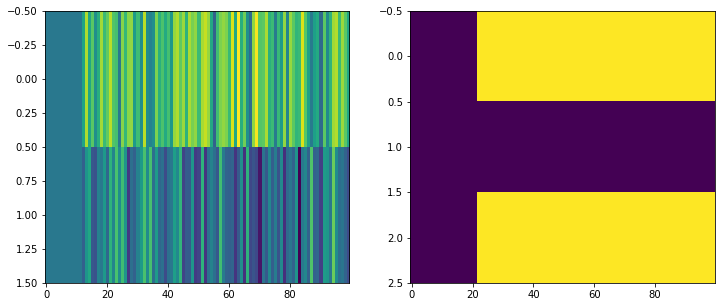

In [360]:
x,y,m = next(gen)
f,ax = plt.subplots(1,2,figsize = (12,5))
ax[0].imshow(x[0,:,:].T,aspect = 'auto')
ax[1].imshow(y[0,:,:].T,aspect = 'auto')

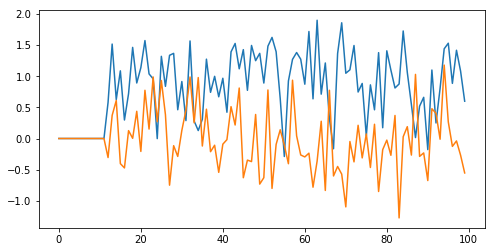

In [362]:
f,ax = plt.subplots(figsize = (8,4))
ax.plot(x[0,:,:]);
# ax.set_xlim((0,50))

In [363]:
params = swv.__dict__
print(params)

{'N_batch': 10, 'N_in': 2, 'N_out': 3, 'dt': 1, 'tau': 10, 'T': 100, 'alpha': 0.1, 'N_steps': 100}


In [422]:
params['name'] = name #Used to scope out a namespace for global variables.
params['N_rec'] = N_rec
params['dale_ratio'] = None # Default: None -- when the dale_ratio is set, dale's law is applied
params['rec_noise'] = 0.05 # Default: 0.0 -- how much noise to add to the new_state calculation
params['W_in_train'] = True # Indicates whether W_in is trainable. Default: True
params['W_rec_train'] = True # Indicates whether W_rec is trainable. Default: True
params['W_out_train'] = True # Indicates whether W_out is trainable. Default: True
params['b_rec_train'] = True # Indicates whether b_rec is trainable. Default: True
params['b_out_train'] = True # Indicates whether b_out is trainable. Default: True
params['init_state_train'] = True # Indicates whether init_state is trainable. Default: True
params['load_weights_path'] = None # When given a path, loads weights from file in that path. Default: None

params['L2_out'] = 0.1
params['L2_rec'] = 0.1
params['L2_in'] = 0.1
params['L2_firing_rate_reg'] = 0

params['L1_firing_rate_reg'] = 0
params['L1_out'] = 1
params['L1_in'] = 1
params['L1_rec'] = 1

Instantiate our model

In [423]:
basicModel.destruct()

In [424]:
basicModel = Basic(params)
basicModel.build()

In [425]:
train_params = {}
train_params['save_weights_path'] =  '../weights/refactor_weights.npz' # Where to save the model after training. Default: None
train_params['training_iters'] = 15000 # number of iterations to train for Default: 10000
train_params['learning_rate'] = .001 # Sets learning rate if use default optimizer Default: .001
train_params['loss_epoch'] = 10 # Compute and record loss every 'loss_epoch' epochs. Default: 10
train_params['verbosity'] = True # If true, prints information as training progresses. Default: True
train_params['save_training_weights_epoch'] = 100 # save training weights every 'save_training_weights_epoch' epochs. Default: 100
train_params['training_weights_path'] = None # where to save training weights as training progresses. Default: None
train_params['generator_function'] = None # replaces trial_batch_generator with the generator_function when not none. Default: None
train_params['optimizer'] = tf.train.AdamOptimizer(learning_rate=train_params['learning_rate']) # What optimizer to use to compute gradients. Default: tf.train.AdamOptimizer(learning_rate=train_params['learning_rate'])
train_params['clip_grads'] = True # If true, clip gradients by norm 1. Default: True
train_params

{'save_weights_path': '../weights/refactor_weights.npz',
 'training_iters': 15000,
 'learning_rate': 0.001,
 'loss_epoch': 10,
 'verbosity': True,
 'save_training_weights_epoch': 100,
 'training_weights_path': None,
 'generator_function': None,
 'optimizer': <tensorflow.python.training.adam.AdamOptimizer at 0x1ae8b4cc0>,
 'clip_grads': True}

In [426]:
basicModel.train(gen, train_params)

Iter 100, Minibatch Loss= 0.394331
Iter 200, Minibatch Loss= 0.322023
Iter 300, Minibatch Loss= 0.285321
Iter 400, Minibatch Loss= 0.280442
Iter 500, Minibatch Loss= 0.264698
Iter 600, Minibatch Loss= 0.234253
Iter 700, Minibatch Loss= 0.203376
Iter 800, Minibatch Loss= 0.204982
Iter 900, Minibatch Loss= 0.204681
Iter 1000, Minibatch Loss= 0.186192
Training weights saved in file: None100
Iter 1100, Minibatch Loss= 0.175279
Iter 1200, Minibatch Loss= 0.185129
Iter 1300, Minibatch Loss= 0.188314
Iter 1400, Minibatch Loss= 0.178416
Iter 1500, Minibatch Loss= 0.174644
Iter 1600, Minibatch Loss= 0.166690
Iter 1700, Minibatch Loss= 0.158777
Iter 1800, Minibatch Loss= 0.148442
Iter 1900, Minibatch Loss= 0.159993
Iter 2000, Minibatch Loss= 0.143034
Training weights saved in file: None200
Iter 2100, Minibatch Loss= 0.146433
Iter 2200, Minibatch Loss= 0.152827
Iter 2300, Minibatch Loss= 0.142339
Iter 2400, Minibatch Loss= 0.145553
Iter 2500, Minibatch Loss= 0.134044
Iter 2600, Minibatch Loss= 0.

([0.39433098,
  0.322023,
  0.28532106,
  0.28044164,
  0.2646979,
  0.23425335,
  0.20337579,
  0.20498163,
  0.20468077,
  0.18619195,
  0.17527878,
  0.18512905,
  0.18831441,
  0.17841572,
  0.17464359,
  0.16668956,
  0.15877748,
  0.148442,
  0.15999307,
  0.14303404,
  0.14643335,
  0.15282688,
  0.14233884,
  0.14555258,
  0.13404424,
  0.13093352,
  0.12812698,
  0.13362603,
  0.13231176,
  0.13079056,
  0.13831897,
  0.13165784,
  0.13178678,
  0.12177929,
  0.11897446,
  0.11945335,
  0.11389361,
  0.11082323,
  0.1180389,
  0.1269485,
  0.114866905,
  0.11118402,
  0.12310304,
  0.106586315,
  0.116986886,
  0.118943706,
  0.10813449,
  0.108689256,
  0.11817311,
  0.11463521,
  0.10363124,
  0.10732791,
  0.11152541,
  0.10939324,
  0.10351202,
  0.09857525,
  0.105037674,
  0.10044244,
  0.10732804,
  0.11241858,
  0.10284759,
  0.09679168,
  0.09410104,
  0.109291345,
  0.09484978,
  0.103006184,
  0.09891843,
  0.100342035,
  0.09260847,
  0.08731625,
  0.096294805,
  0

In [427]:
x,y,m = next(gen)
results = basicModel.test(x)
output = results[0]
state_var = results[1]

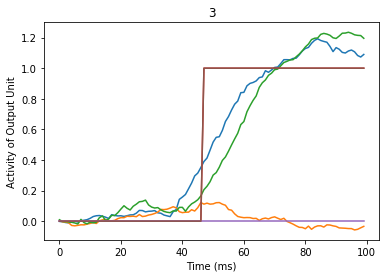

In [428]:
i = np.random.choice(output.shape[0])
plt.plot(range(0, len(output[i,:,:])*dt,dt),output[i,:,:])
plt.ylabel("Activity of Output Unit")
plt.xlabel("Time (ms)")
plt.title(i)
plt.plot(range(0, len(y[i,:,:])*dt,dt), y[i,:,:])

In [429]:
weights = basicModel.get_weights()
E = np.diag(weights['Dale_rec'])>0
I = np.diag(weights['Dale_rec'])<0
inputw, outputw, allw = weight_concat(basicModel)

In [430]:
def weight_concat(model):
    weights = model.get_weights()
    inputw = np.concatenate([weights['W_in'],weights['W_rec']],axis = 1)
    outputw = np.concatenate([weights['W_rec'].T,weights['W_out'].T],axis = 1)
    allw = np.concatenate([inputw,outputw],axis = 1)
    return inputw, outputw, allw

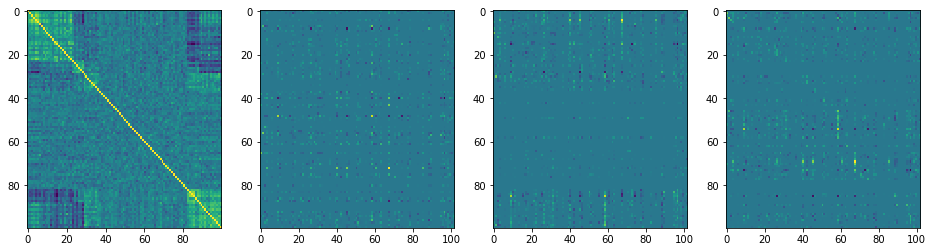

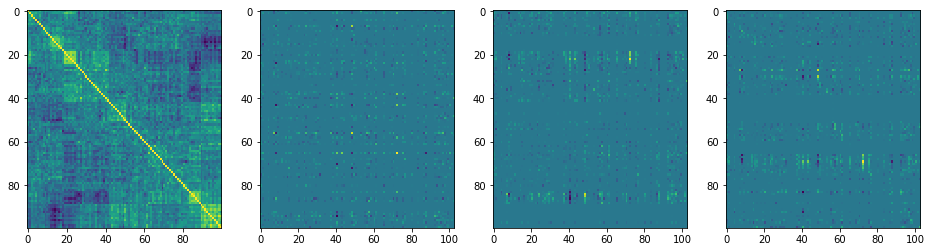

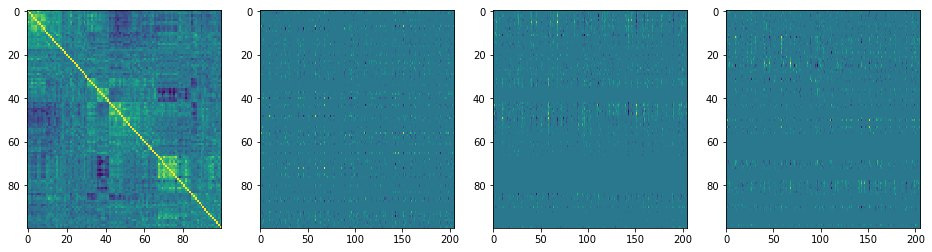

In [438]:
weight_sort_plot(inputw)
weight_sort_plot(outputw)
weight_sort_plot(allw)

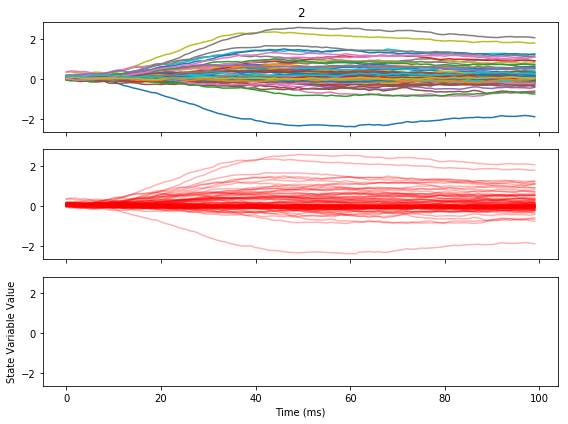

In [431]:
f,ax = plt.subplots(3,1,figsize = (8,6),sharex = True, sharey = True)

i = np.random.choice(output.shape[0])
ax[0].plot(range(0, len(state_var[i,:,:])*dt,dt),state_var[i,:,:])
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
ax[0].set_title(i)

for ind in np.where(E)[0]:
    ax[1].plot(range(0, len(state_var[i,:,ind])*dt,dt),state_var[i,:,ind],'r',alpha = 0.3)
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")

for ind in np.where(I)[0]:
    ax[2].plot(range(0, len(state_var[i,:,ind])*dt,dt),state_var[i,:,ind],'b',alpha = 0.3)
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.tight_layout()

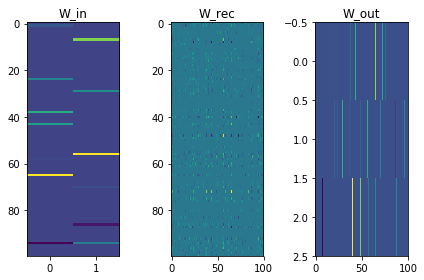

In [432]:
f,ax = plt.subplots(1,3)
for axi,key in  enumerate(['W_in', 'W_rec', 'W_out']):
    ax[axi].imshow(weights[key],aspect = 'auto')
    ax[axi].set_title(key)
plt.tight_layout()

In [420]:
import scipy.cluster.hierarchy as spc

def weight_sort_plot(W):
    this_W = W
    corr = np.corrcoef(this_W)
    pdist = spc.distance.pdist(corr)
    linkage = spc.linkage(pdist, method='complete')
    corr_idx = np.argsort(spc.fcluster(linkage, 0.5 * pdist.max(), 'distance'))
    corr_sort = np.corrcoef(this_W[corr_idx])
    max_idx = np.argsort(np.argmax(this_W,axis = 1))
    f,ax = plt.subplots(1,4,figsize = (16,4))
    ax[0].imshow(corr_sort,aspect = 'auto')
    ax[1].imshow(this_W,aspect = 'auto')
    ax[2].imshow(this_W[corr_idx,:],aspect = 'auto')
    ax[3].imshow(this_W[max_idx,:],aspect = 'auto')
     

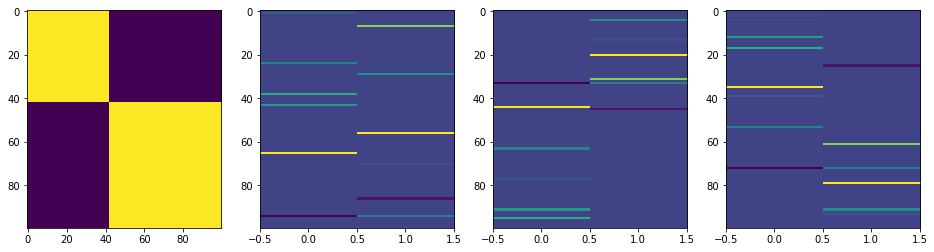

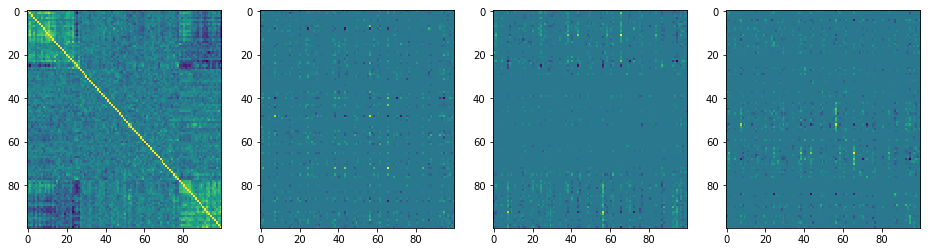

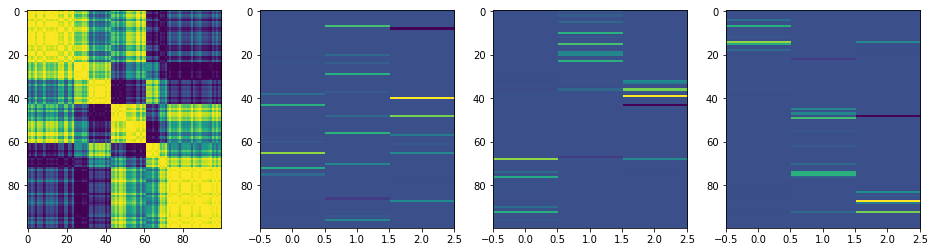

In [433]:
weight_sort_plot(weights['W_in'][E,:])
weight_sort_plot(weights['W_rec'][E,:])
weight_sort_plot(weights['W_out'][:,E].T)

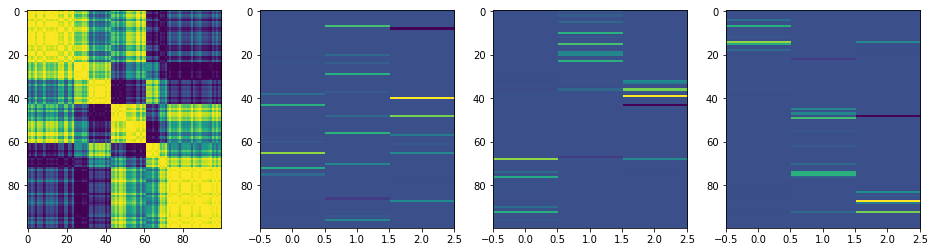

In [434]:
# this_W = weights['W_in'][E,:]
this_W = weights['W_out'][:,E].T
# this_W = weights['W_rec'][E,:]
corr = np.corrcoef(this_W)
pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
corr_idx = np.argsort(spc.fcluster(linkage, 0.5 * pdist.max(), 'distance'))
corr_sort = np.corrcoef(this_W[corr_idx])
max_idx = np.argsort(np.argmax(this_W,axis = 1))
f,ax = plt.subplots(1,4,figsize = (16,4))
ax[0].imshow(corr_sort,aspect = 'auto')
ax[1].imshow(this_W,aspect = 'auto')
ax[2].imshow(this_W[corr_idx,:],aspect = 'auto')
ax[3].imshow(this_W[max_idx,:],aspect = 'auto')
this_idx = corr_idx


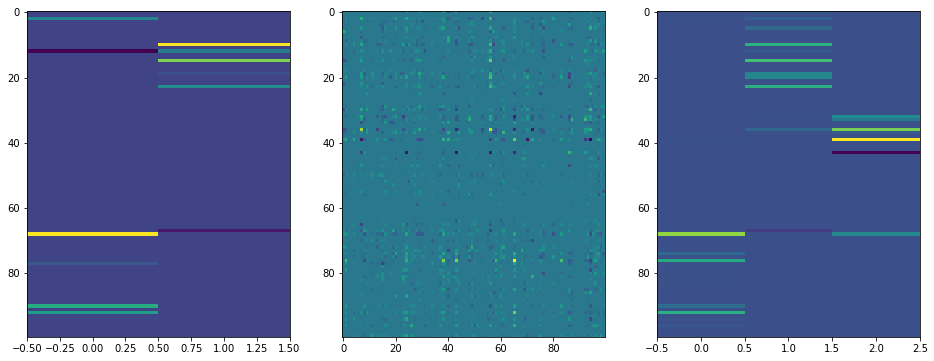

In [435]:
f,ax = plt.subplots(1,3,figsize = (16,6))
ax[0].imshow(weights['W_in'][this_idx,:],aspect = 'auto')
ax[1].imshow(weights['W_rec'][this_idx,:],aspect = 'auto')
ax[2].imshow(weights['W_out'][:,this_idx].T,aspect = 'auto')

In [350]:
weights['W_out'].shape

(3, 100)

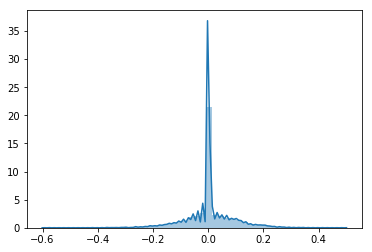

In [404]:
import seaborn as sns
sns.distplot(allw.flatten())

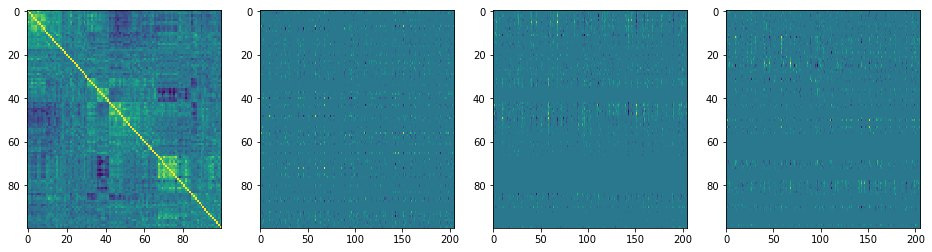

In [436]:
weight_sort_plot(allw[E,:])

In [ ]:
dale_vec = np.ones(N_rec)
        
dale_vec[int(dale_ratio * N_rec):] = -1
dale_rec = np.diag(dale_vec)
dale_vec[int(dale_ratio * N_rec):] = 0
dale_out = np.diag(dale_vec)

In [ ]:
dale_rec

Clean up the model to clear out the tensorflow namespace

In [ ]:
basicModel.destruct()

In [ ]:
def gaussian_psth(mu = 0 * ms, sigma = 0 * ms):
        time_bins = np.arange(0,T,dt)
        mu_ = mu 
        sigma_ = sigma  
        psth = (1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (time_bins - mu)**2 / (2 * sigma**2)))
        psth = psth/sum(psth)
        return psth,time_bins
    
def uniform_psth():
        time_bins = np.arange(0,T,dt)
        psth = np.ones(time_bins.shape)*dt/second
        return psth,time_bins

def spikes_from_psth(psth):
    return np.random.binomial(1,psth)

def generate_population_spikes(kernel,rates):
    spikes = []
    ind = []
    for i,r in enumerate(rates):
        this_spikes = np.where(spikes_from_psth(kernel*r))[0]
        this_ind = np.ones(this_spikes.shape) * i
        spikes.append(this_spikes)
        ind.append(this_ind)
    spikes = np.concatenate(spikes) *dt
    ind = np.concatenate(ind).astype(int)
    return spikes, ind    

def diff_of_exps(x_range,tau_rise = 1,tau_decay = 3, onset = 0):
    y = np.zeros(x_range.shape)
    for i,x in enumerate(x_range):
        y[i] = (1/np.exp((x-onset)/tau_decay)) - (1/np.exp((x-onset)/tau_rise))
    y[y<0] = 0
    return y 
#     onset_time = int(kernel_length*onset)
alpha_k = diff_of_exps(np.arange(30),tau_rise = 0.1,tau_decay = 3, onset = 14)   
plt.plot(np.arange(30),alpha_k)